In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
import seaborn as sns
import matplotlib.pyplot as plt
import string
import joblib
from sklearn.metrics import f1_score
from scipy.optimize import minimize_scalar
from sklearn.inspection import permutation_importance

In [2]:
new_df = pd.read_csv("../csv_file/new_fake_news_df.csv") 

In [3]:
new_df .info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38647 entries, 0 to 38646
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   headlines  38647 non-null  object
 1   outcome    38647 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 604.0+ KB


In [4]:
new_df.head()

,headlines,outcome
0,"Donald Trump s White House is in chaos, and th...",1
1,Now that Donald Trump is the presumptive GOP n...,1
2,Mike Pence is a huge homophobe. He supports ex...,1
3,SAN FRANCISCO (Reuters) - California Attorney ...,0
4,Twisted reasoning is all that comes from Pelos...,1


In [2]:
data = pd.read_csv("../csv_file/big_data.csv") 

In [3]:
# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Download spaCy model
spacy.cli.download("en_core_web_sm")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\soder\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\soder\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\soder\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [4]:
# Load spaCy model
nlp = spacy.load('en_core_web_sm')

In [4]:
def count_words(text):
    tokens = nlp(text)
    return len(tokens)

In [5]:
def preprocess_text(text, use_lemmatization=True):
    # Lowercasing
    text = text.lower()
    
    # Tokenization using spaCy
    tokens = nlp(text)
    tokens = [token.text for token in tokens]
    
    # Punctuation Removal
    tokens = [token for token in tokens if token not in string.punctuation]
    
    # Stop Word Removal
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    # Stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]
    
    # Lemmatization (optional)
    if use_lemmatization:
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    return tokens

In [6]:
data['processed_text'] = data['headlines'].apply(preprocess_text)

new_df['processed_text'] = new_df['headlines'].apply(preprocess_text)

In [7]:
max_features_value = 15000

max_features_value = 20000

In [8]:
tfidf_vectorizer = TfidfVectorizer(max_features=max_features_value)

In [9]:
X_tfidf = tfidf_vectorizer.fit_transform(data['processed_text'].apply(lambda x: ' '.join(x)))

X_tfidf = tfidf_vectorizer.fit_transform(new_df['processed_text'].apply(lambda x: ' '.join(x)))

In [10]:
# Split the data into training and testing sets
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf, data['outcome'], test_size=0.2, random_state=42)

X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf, new_df['outcome'], test_size=0.2, random_state=42)

In [11]:
param_grid = {
    'C': [0.1, 1, 10, 100],      
    'kernel': ['linear', 'rbf'],   
    'gamma': [0.01, 0.1, 1, 'auto']
}

svm_model = SVC()

In [12]:
svm_model = SVC(probability=True, C=10, gamma=1, kernel="rbf")  

In [13]:
grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring='accuracy')

In [14]:
svm_model.fit(X_train_tfidf, y_train)

SVC(C=10, gamma=1, probability=True)

In [ ]:
print("Duplicates:", new_df.duplicated().sum())

In [37]:
best_param = grid_search.best_params_

In [38]:
print("Best Hyperparameters:", best_param)

Best Hyperparameters: {'C': 10, 'gamma': 1, 'kernel': 'rbf'}


In [15]:
y_pred_best = svm_model.predict(X_test_tfidf)

In [16]:
y_pred_best

array([1, 0, 1, ..., 1, 1, 1], dtype=int64)

y_pred_prob = svm_model.predict_proba(X_test_tfidf)[:, 1]

objective_func = lambda threshold: -f1_score(y_test, y_pred_prob > threshold)

result = minimize_scalar(objective_func, bounds=(0, 1), method='bounded')

optimal_threshold = result.x
print("Optimal Threshold:", optimal_threshold)

In [59]:
accuracy_best = accuracy_score(y_test, y_pred_best)
print(f'Best Model Accuracy: {accuracy_best}')

Best Model Accuracy: 0.9282247765006386


joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer3.joblib')
joblib.dump(svm_model, 'svm_model3.joblib')

Text(0.5, 1.0, 'Confusion Matrix')

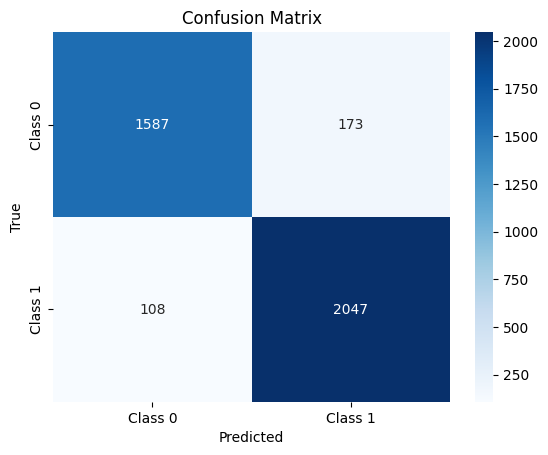

In [82]:
conf_matrix = confusion_matrix(y_test, y_pred_best)

# Create a heatmap of the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

In [83]:
print("Classification Report:\n", classification_report(y_test, y_pred_best))

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.90      0.92      1760
           1       0.92      0.95      0.94      2155

    accuracy                           0.93      3915
   macro avg       0.93      0.93      0.93      3915
weighted avg       0.93      0.93      0.93      3915



In [11]:
loaded_tfidf_vectorizer = joblib.load('../trained_models_and_preprocessing pipeline/svm_model/tfidf_vectorizer3.joblib')
loaded_svm_model = joblib.load('../trained_models_and_preprocessing pipeline/svm_model/svm_model3.joblib')

In [12]:
test_data = pd.read_csv("../csv_file/test_data.csv") 

In [13]:
X = test_data["headlines"]
y = test_data["outcome"]

In [14]:
processed_text = [preprocess_text(x) for x in X]

In [15]:
processed_text_strings = [' '.join(text) for text in processed_text]

In [16]:
tfidf_features = loaded_tfidf_vectorizer.transform(processed_text_strings)

In [17]:
predictions = loaded_svm_model.predict(tfidf_features)

predictions = best_svm_model.predict(tfidf_features)

In [17]:
accuracy = accuracy_score(y, predictions)

In [18]:
print(accuracy)

0.905


opt_threshold = optimal_threshold  
decision_function_values = svm_model.decision_function(X_test_tfidf)
binary_predictions = (decision_function_values >= optimal_threshold).astype(int)

In [19]:
threshold = 0.5

In [20]:
binary_predictions = (predictions >= threshold).astype(int)

In [21]:
for index, title in enumerate(X):
    prediction = binary_predictions[index]
    outcome = y.iloc[index]
    
    if outcome == 1:
        outcome = "Fake"
    else:
        outcome = "Real"
        
    if prediction == 1:
        prediction = "Fake"
    else:
        prediction = "Real"
    print(f"Title: {title}")
    print(f"Real Outcome: {outcome}")
    print(f"Prediction: {prediction}")
    print("=" * 50)

Title: CDC has given more than $200M to address #COVID19 health disparities among American Indian &amp; Alaska Native people who have suffered a disproportionate burden of illness. Funding will broaden access to COVID-19 resources across tribal communities. https://t.co/MG8e5TWigl https://t.co/KwoPLuxG4g
Real Outcome: Real
Prediction: Real
Title: #IndiaFightsCorona TEST TRACK TREAT- effective implementation by the Centre and States/UTs has ensured that India has one of lowest #COVID19 cases and deaths per million population compared to several other countries. https://t.co/Caqhv0M0rK
Real Outcome: Real
Prediction: Real
Title: Ireland's entire cabinet will "restrict their movements" after the health minister felt unwell and was tested for #coronavirus it has been reported https://t.co/i5zO9bFugY
Real Outcome: Real
Prediction: Fake
Title: The Chairman of the Republican Party of Texas said the recovery rate for COVID-19 is 99.9% in Texas. That’s False. @PolitiFactTexas https://t.co/GmUXoV

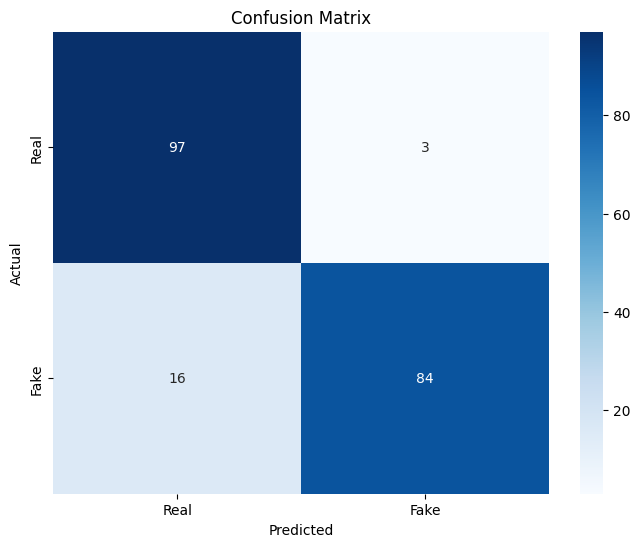

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.97      0.91       100
           1       0.97      0.84      0.90       100

    accuracy                           0.91       200
   macro avg       0.91      0.91      0.90       200
weighted avg       0.91      0.91      0.90       200



In [22]:
cm = confusion_matrix(y, binary_predictions)

# Display confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Display classification report
print("Classification Report:\n", classification_report(y, binary_predictions))

In [18]:
decision_values = loaded_svm_model.decision_function(tfidf_features)

In [19]:
for i, decision_value in enumerate(decision_values):
    print(f"Row {i+1}: Decision Value = {decision_value}")

Row 1: Decision Value = -0.6365119349399508
Row 2: Decision Value = -1.2068824855641995
Row 3: Decision Value = 0.20196869215410876
Row 4: Decision Value = 0.48060512579783704
Row 5: Decision Value = 0.7198758537288821
Row 6: Decision Value = 0.7651596119918864
Row 7: Decision Value = -1.2882090402766526
Row 8: Decision Value = 0.4541579451910731
Row 9: Decision Value = 1.406989401945627
Row 10: Decision Value = -0.9798702067683558
Row 11: Decision Value = -1.5188670974397263
Row 12: Decision Value = -0.014934945119356335
Row 13: Decision Value = 0.7552795875796185
Row 14: Decision Value = -1.3125747808149666
Row 15: Decision Value = -0.6516085615329905
Row 16: Decision Value = 0.7254662419780971
Row 17: Decision Value = -1.28417186934222
Row 18: Decision Value = 0.6664919141506112
Row 19: Decision Value = -0.842245945178459
Row 20: Decision Value = -1.1733278171137733
Row 21: Decision Value = 1.3667387016560575
Row 22: Decision Value = -1.1758897574174174
Row 23: Decision Value = 0.96

In [20]:
probabilities = loaded_svm_model.predict_proba(tfidf_features)

In [21]:
probabilities = loaded_svm_model.predict_proba(tfidf_features)

for i, probability in enumerate(probabilities[:, 1]):  
    print(f"Row {i+1}: Probability = {probability * 100:.2f}%")

for i, probability in enumerate(probabilities[:, 0]):  
    print(f"Row {i+1}: Probability = {probability * 100:.2f}%")


Row 1: Probability = 3.73%
Row 2: Probability = 0.23%
Row 3: Probability = 69.98%
Row 4: Probability = 90.20%
Row 5: Probability = 96.76%
Row 6: Probability = 97.39%
Row 7: Probability = 0.15%
Row 8: Probability = 88.99%
Row 9: Probability = 100.00%
Row 10: Probability = 0.69%
Row 11: Probability = 0.05%
Row 12: Probability = 44.48%
Row 13: Probability = 97.27%
Row 14: Probability = 0.13%
Row 15: Probability = 3.46%
Row 16: Probability = 96.85%
Row 17: Probability = 0.15%
Row 18: Probability = 95.83%
Row 19: Probability = 1.36%
Row 20: Probability = 0.27%
Row 21: Probability = 100.00%
Row 22: Probability = 0.26%
Row 23: Probability = 99.01%
Row 24: Probability = 0.83%
Row 25: Probability = 0.30%
Row 26: Probability = 89.13%
Row 27: Probability = 0.58%
Row 28: Probability = 7.40%
Row 29: Probability = 99.47%
Row 30: Probability = 98.77%
Row 31: Probability = 10.12%
Row 32: Probability = 0.22%
Row 33: Probability = 0.65%
Row 34: Probability = 0.11%
Row 35: Probability = 99.16%
Row 36: Pr

In [22]:
for i, probability in enumerate(probabilities[:, 0]):  
    print(f"Row {i+1}: Probability = {probability * 100:.2f}%")

Row 1: Probability = 96.27%
Row 2: Probability = 99.77%
Row 3: Probability = 30.02%
Row 4: Probability = 9.80%
Row 5: Probability = 3.24%
Row 6: Probability = 2.61%
Row 7: Probability = 99.85%
Row 8: Probability = 11.01%
Row 9: Probability = 0.00%
Row 10: Probability = 99.31%
Row 11: Probability = 99.95%
Row 12: Probability = 55.52%
Row 13: Probability = 2.73%
Row 14: Probability = 99.87%
Row 15: Probability = 96.54%
Row 16: Probability = 3.15%
Row 17: Probability = 99.85%
Row 18: Probability = 4.17%
Row 19: Probability = 98.64%
Row 20: Probability = 99.73%
Row 21: Probability = 0.00%
Row 22: Probability = 99.74%
Row 23: Probability = 0.99%
Row 24: Probability = 99.17%
Row 25: Probability = 99.70%
Row 26: Probability = 10.87%
Row 27: Probability = 99.42%
Row 28: Probability = 92.60%
Row 29: Probability = 0.53%
Row 30: Probability = 1.23%
Row 31: Probability = 89.88%
Row 32: Probability = 99.78%
Row 33: Probability = 99.35%
Row 34: Probability = 99.89%
Row 35: Probability = 0.84%
Row 36

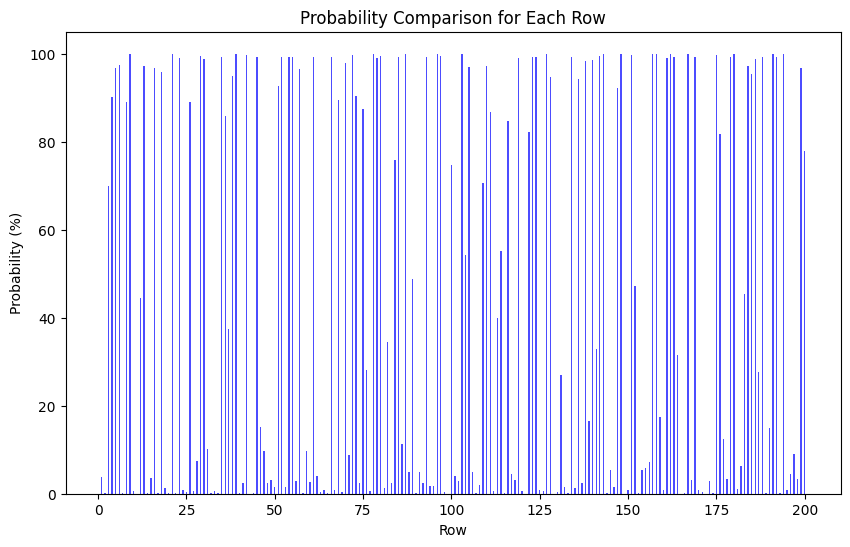

In [22]:
import matplotlib.pyplot as plt

def plot_probabilities(probabilities):
    fig, ax = plt.subplots(figsize=(10, 6))

    # Extract row indices for x-axis
    rows = range(1, len(probabilities) + 1)

    # Adjusted bar width for better visibility
    bar_width = 0.4

    # Plot the probabilities as a barplot
    ax.bar(rows, probabilities[:, 1] * 100, color='blue', alpha=0.7, width=bar_width)

    # Add labels and title
    ax.set_xlabel('Row')
    ax.set_ylabel('Probability (%)')
    ax.set_title('Probability Comparison for Each Row')

    # Show the plot
    plt.show()


# Example of using the plot_probabilities function
plot_probabilities(probabilities)


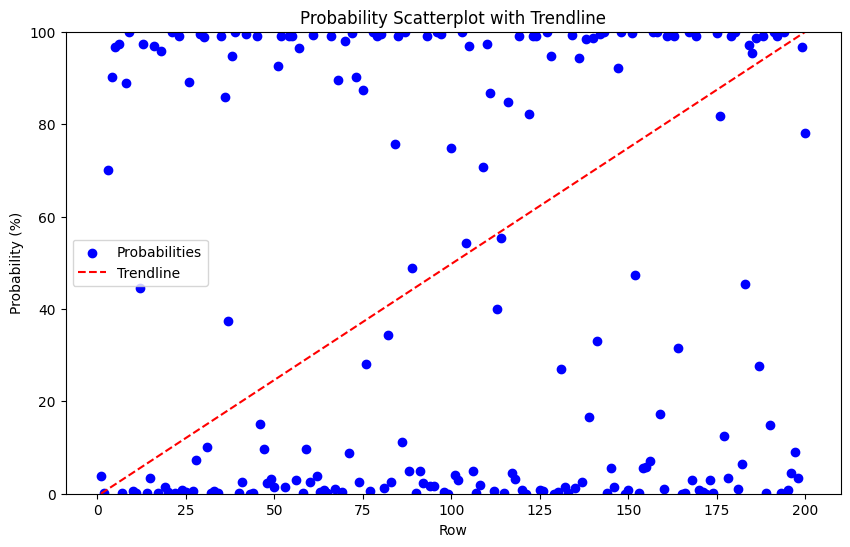

In [24]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

def plot_probabilities_scatter(probabilities):
    fig, ax = plt.subplots(figsize=(10, 6))

    # Extract row indices for x-axis
    rows = range(1, len(probabilities) + 1)

    # Scatter plot of the probabilities
    ax.scatter(rows, probabilities[:, 1] * 100, color='blue', label='Probabilities')

    # Add labels and title
    ax.set_xlabel('Row')
    ax.set_ylabel('Probability (%)')
    ax.set_title('Probability Scatterplot with Trendline')

    # Add a trendline (linear regression)
    lr = LinearRegression()

    # Fit the trendline through points (1, 0%) and (n, 100%)
    lr.fit(np.array([1, len(rows)]).reshape(-1, 1), [0, 100])
    trendline_x = np.array(rows)
    trendline_y = lr.predict(trendline_x.reshape(-1, 1))
    ax.plot(trendline_x, trendline_y, color='red', linestyle='--', label='Trendline')

    # Set y-axis limits from 0% to 100%
    ax.set_ylim(0, 100)

    # Show legend
    ax.legend()

    # Show the plot
    plt.show()



# Example of using the plot_probabilities_scatter function
plot_probabilities_scatter(probabilities)



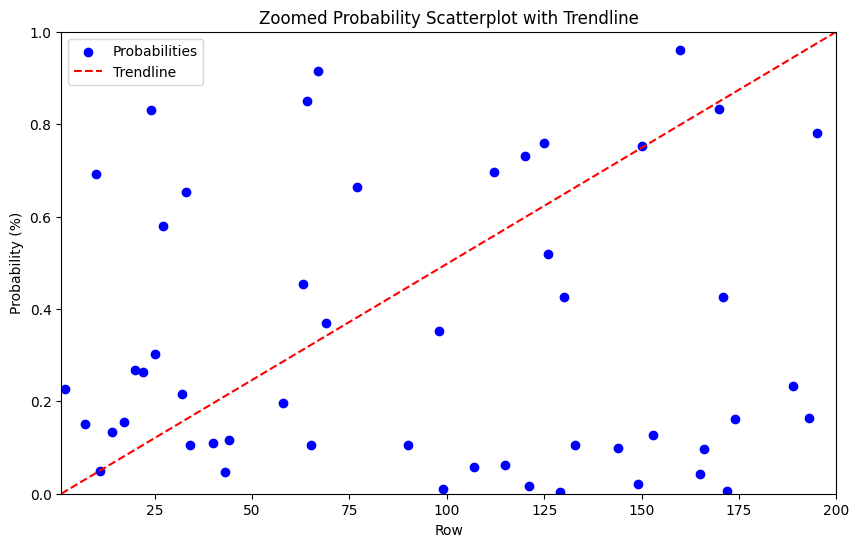

In [27]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

def plot_probabilities_zoomed(probabilities):
    fig, ax = plt.subplots(figsize=(10, 6))

    # Extract row indices for x-axis
    rows = range(1, len(probabilities) + 1)

    # Scatter plot of the probabilities
    ax.scatter(rows, probabilities[:, 1] * 100, color='blue', label='Probabilities')

    # Add labels and title
    ax.set_xlabel('Row')
    ax.set_ylabel('Probability (%)')
    ax.set_title('Zoomed Probability Scatterplot with Trendline')

    # Add a trendline (linear regression)
    lr = LinearRegression()

    # Fit the trendline through points (1, 0%) and (n, 10%)
    lr.fit(np.array([1, len(rows)]).reshape(-1, 1), [0, 1])
    trendline_x = np.array(rows)
    trendline_y = lr.predict(trendline_x.reshape(-1, 1))
    ax.plot(trendline_x, trendline_y, color='red', linestyle='--', label='Trendline')

    # Set y-axis limits from 0% to 10%
    ax.set_ylim(0, 1)

    # Set x-axis limits to only show points within the zoomed-in range
    ax.set_xlim(min(rows), max(rows))

    # Show legend
    ax.legend()

    # Show the plot
    plt.show()



# Example of using the plot_probabilities_zoomed function
plot_probabilities_zoomed(probabilities)


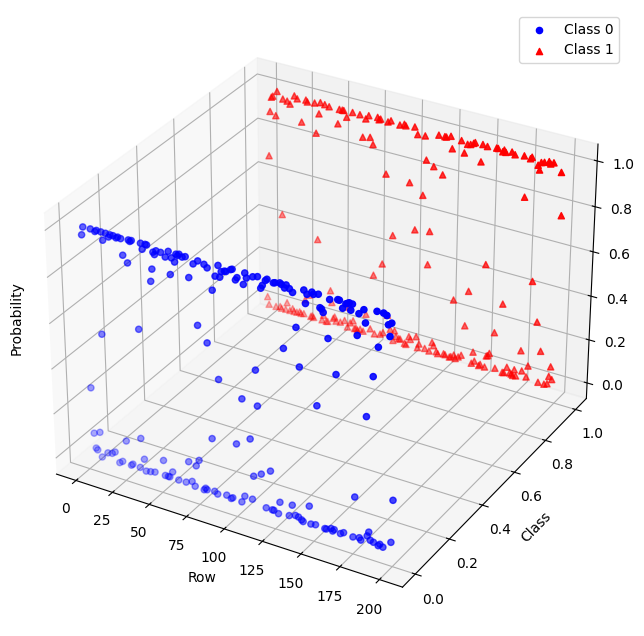

In [42]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_probabilities_3d(probabilities, save_path=None):
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    rows = range(1, len(probabilities) + 1)

    # Plot the probabilities for Class 0
    ax.scatter(rows, [0] * len(rows), probabilities[:, 0], color='blue', label='Class 0', marker='o')

    # Plot the probabilities for Class 1
    ax.scatter(rows, [1] * len(rows), probabilities[:, 1], color='red', label='Class 1', marker='^')

    ax.set_xlabel('Row')
    ax.set_ylabel('Class')
    
    # Manually add label to the z-axis
    ax.text2D(0, 0.5, 'Probability', transform=ax.transAxes, rotation=90, va='center')

    plt.legend()

    # Save the figure if save_path is provided
    if save_path:
        plt.savefig(save_path, format='png', bbox_inches='tight', transparent=True)

    plt.show()



# Example of using the plot_probabilities_3d function and saving the figure
plot_probabilities_3d(probabilities, save_path='../images/3d_plot.png')


In [15]:
X_tfidf = loaded_tfidf_vectorizer.transform(data['headlines'])

In [16]:
X_tfidf_dense = X_tfidf.toarray()

In [17]:
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf_dense, data['outcome'], test_size=0.2, random_state=42)

joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer2.joblib')
joblib.dump(best_svm_model, 'svm_model2.joblib')